# Use skorch to do random Hyperparameter search for 5G RNA-seq data (single-task)
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model

## *** Log(TPM) 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


## Load 5G data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY_log = pd.read_csv(log_data_filename,sep='\t')

display(XY_log.head())

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


In [5]:
loc2seq = dict([(x,z) for (x,z) in XY_log[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


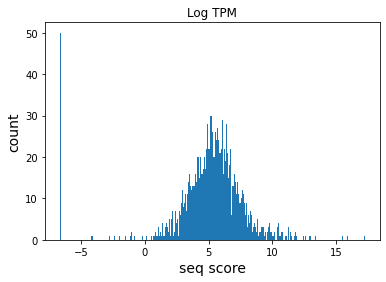

In [6]:
plt.hist(XY_log['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

In [7]:
for df in [XY_log]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

## Load 5G seqs into data loaders

In [9]:
# LOG
log_full_train_df,log_test_df = tu.quick_split(XY_log)
log_train_df, log_val_df = tu.quick_split(log_full_train_df)

print(log_full_train_df.shape)
print(log_test_df.shape)
print(log_train_df.shape)
print(log_val_df.shape)

assert(log_train_df.shape[0] + log_val_df.shape[0] == log_full_train_df.shape[0])

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


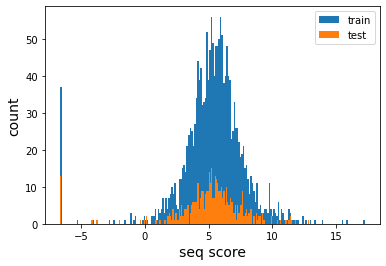

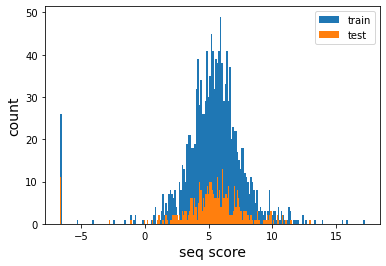

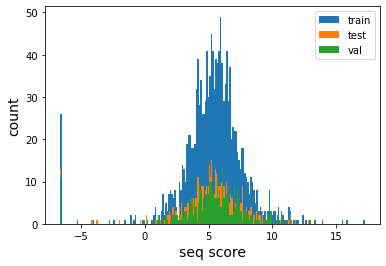

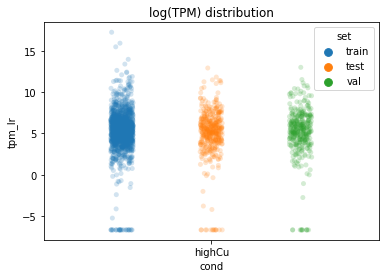

In [10]:
plot_train_test_hist(log_full_train_df, log_test_df,score_col='highCu',bins=200)
plot_train_test_hist(log_train_df, log_val_df,score_col='highCu',bins=200)

plot_train_test_hist(log_train_df, log_test_df, val_df=log_val_df,score_col='highCu',bins=200)
view_train_test_dist(log_train_df, log_test_df,["highCu"],"log(TPM)",val_df=log_val_df)


In [11]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [12]:
# Dfs for the full train/test split
log_final_dls = tu.build_dataloaders_single(
    log_full_train_df, 
    log_test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu')

# Dfs from further spliting train into train and val
log_dls = tu.build_dataloaders_single(
    log_train_df, 
    log_val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
log_ohe_train_dl,log_ohe_val_dl = log_dls['ohe']

In [13]:
len(log_kmer6_train_dl.dataset.kmers)

4096

In [14]:
log_ohe_train_dl

## define basic single task models

In [15]:
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
            #nn.ReLU(inplace=True),
            nn.Linear(num_fc_nodes2, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

## training loop defs

In [16]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

def quick_loss_plot_simple(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        # plot only 1 in every sparse_n points
        if sparse_n:
            train_data = [x for i,x in enumerate(train_data) if (i%sparse_n==0)]
            test_data = [x for i,x in enumerate(test_data) if (i%sparse_n==0)]
            
        plt.plot(train_data,'--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,'o-',color=f"C{i}", label=f"{label} Test",linewidth=3.0)
        

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

In [17]:
seq_len = len(log_train_df['upstream_region'].values[0])
model_cnn = DNA_CNN(
    seq_len,
    num_filters=128,
    kernel_size=8,
    num_fc_nodes1=10
)
model_cnn.to(DEVICE)

train_losses_cnn, \
test_losses_cnn = run_model(
    log_ohe_train_dl, 
    log_ohe_val_dl, 
    model_cnn, 
    lr=0.0001,
    epochs=100,
)

# to plot loss
cnn_data_label = [((train_losses_cnn,test_losses_cnn),'CNN(my fit)')]


0 23.526692549837886
1 15.45341194790416
2 10.841087865424223
3 8.945773219251768
4 8.774251874377978
5 8.795799507973214
6 8.781414235955257
7 8.800366611048453
8 8.967352752307319
9 8.783871907350361
10 8.747124597641294
11 8.778201272062134
12 8.803067191126663
13 8.711755574256097
14 8.757779644163742
15 8.709890711408837
16 8.699412329676468
17 8.723151071888866
18 8.702789101316975
19 8.704639199772908
20 8.687652079984757
21 8.685889733074069
22 8.677740137570304
23 8.720340545049133
24 8.71008258500788
25 8.717565173130197
26 8.68562561797015
27 8.632825936541678
28 8.635796726594227
29 8.635542945213427
30 8.703846612665538
31 8.59109251492422
32 8.597253003809337
33 8.60353962220146
34 8.5727428025632
35 8.569250755201994
36 8.573160557841444
37 8.582126060896487
38 8.613667851466971
39 8.6033591413633
40 8.57835285386688
41 8.546060685057816
42 8.53093126340223
43 8.523474382611239
44 8.51465601961606
45 8.608138653104096
46 8.504745985901051
47 8.505868944162687
48 8.509325

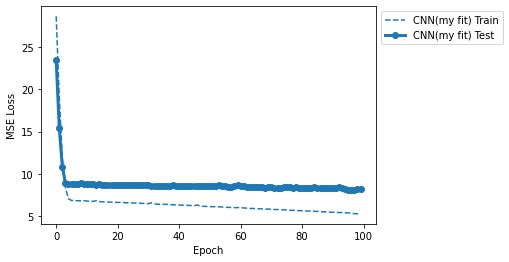

In [18]:
quick_loss_plot_simple(cnn_data_label)


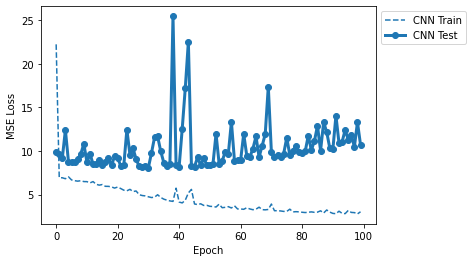

In [101]:
quick_loss_plot_simple(cnn_data_label)


## try fitting with skorch instead

In [19]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    return ohe_seqs.float(), labels.float()

In [20]:
log_val_df.shape

(353, 20)

In [21]:
X, y = make_skorch_dfs(log_full_train_df, seq_col='upstream_region',target_col='highCu')

In [22]:
X.shape

torch.Size([1763, 300, 4])

In [23]:
y.shape

torch.Size([1763, 1])

In [24]:
net_regr = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
)

In [25]:
net_regr.fit(X, y)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       22.7694        7.3966  0.0451
      2        7.3537        8.5228  0.0443
      3        7.3742        8.3876  0.0439
      4        7.3100        8.2278  0.0437
      5        7.2424        8.0509  0.0438
      6        7.1713        7.8642  0.0436
      7        7.0969        7.6767  0.0435
      8        7.0199        7.4974  0.0429
      9        6.9410        7.3342  0.0429
     10        6.8612        7.1926  0.0428
     11        6.7810        7.0750  0.0429
     12        6.7011        6.9802  0.0424
     13        6.6214        6.9049  0.0425
     14        6.5418        6.8446  0.0427
     15        6.4619        6.7947  0.0429
     16        6.3815        6.7515  0.0430
     17        6.3000        6.7123  0.0430
     18        6.2173        6.6753  0.0434
     19        6.1331        6.6392  0.0425
     20        6.0474        6.6036  0.0426
     21        5.9600        6.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [136]:
#y_pred = net_regr.predict(X[:5])
y_pred = net_regr.predict(X)
y_pred = torch.tensor(y_pred).to(DEVICE)


In [138]:
X.shape

torch.Size([1763, 300, 4])

In [27]:
y[:5]

tensor([[6.3058],
        [5.0676],
        [4.8587],
        [2.9824],
        [3.1898]])

In [28]:
net_regr.get_loss(y_pred, y[:5])

tensor(4.4726, device='cuda:0')

In [29]:
torch.tensor(y_pred)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[5.9069],
        [8.7895],
        [7.4501],
        [3.7733],
        [4.1946]], device='cuda:0')

In [30]:
net_regr.train_split

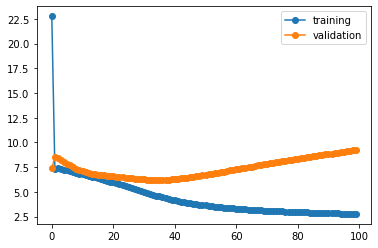

In [31]:
train_loss = net_regr.history[:, 'train_loss']
valid_loss = net_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [32]:
len(net_regr.history)

100

In [33]:
skorch_label = [((net_regr.history[:, 'train_loss'], net_regr.history[:, 'valid_loss']), 'CNN')]

## now try random search with some params

In [34]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform,uniform
from random import randint


In [35]:
net_search = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
)

In [36]:
params = {
    'lr': [0.001, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

In [89]:
#loguniform(0.0001, 0.01)
#u = uniform(4,12)


In [37]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=100, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,#cv, 
    random_state=1,
    verbose=2
)

In [38]:
search.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 10.1min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       25.0530       18.8584  0.0406
      2       16.6744       13.9938  0.0395
      3       12.7827       11.1819  0.0387
      4       10.4721        9.4648  0.0385


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.6min finished


      5        9.0592        8.4194  0.0386
      6        8.2055        7.8003  0.0388
      7        7.7053        7.4491  0.0384
      8        7.4239        7.2602  0.0387
      9        7.2725        7.1651  0.0386
     10        7.1939        7.1206  0.0395
     11        7.1534        7.1013  0.0385
     12        7.1308        7.0932  0.0393
     13        7.1157        7.0892  0.0384
     14        7.1027        7.0859  0.0383
     15        7.0897        7.0823  0.0378
     16        7.0757        7.0777  0.0383
     17        7.0608        7.0724  0.0386
     18        7.0451        7.0665  0.0383
     19        7.0286        7.0600  0.0382
     20        7.0115        7.0533  0.0377
     21        6.9941        7.0462  0.0377
     22        6.9763        7.0390  0.0382
     23        6.9582        7.0317  0.0386
     24        6.9399        7.0243  0.0388
     25        6.9214        7.0168  0.0387
     26        6.9026        7.0092  0.0386
     27        6.8837        7.0

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN'>,
  module__seq_len=300,
),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class 'torch.o

In [39]:
print(search.best_params_)
print(search.best_estimator_)

{'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__num_filters': 32, 'module__num_fc_nodes1': 100, 'module__kernel_size': 8, 'lr': 1e-05}
<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9376, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)


In [40]:
search_label2 = [((search.best_estimator_.history[:, 'train_loss'], search.best_estimator_.history[:, 'valid_loss']), 'CNN search2')]

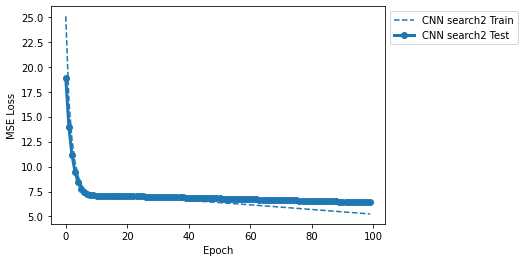

In [41]:
quick_loss_plot_simple(search_label2)

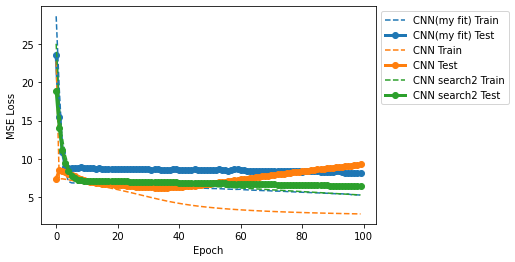

In [44]:
quick_loss_plot_simple(cnn_data_label+ skorch_label+search_label2)

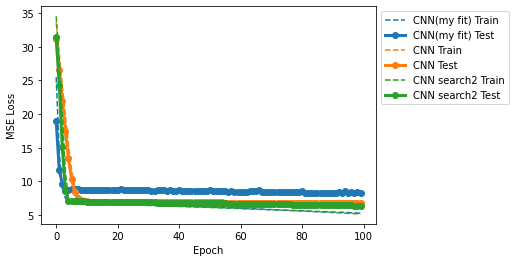

In [95]:
quick_loss_plot_simple(cnn_data_labeldata_labeldata_label+ search_label+search_label2)

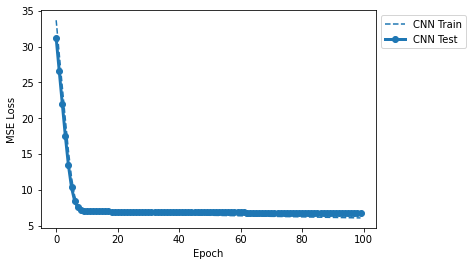

In [36]:
quick_loss_plot_simple(search_label)

In [45]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,8.623698,1.251230,0.008577,0.000568,<class 'torch.optim.adam.Adam'>,16,10,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-15.954004,-15.121257,-17.183037,-16.931883,-19.731236,-16.984283,1.556942,74,Adam
1,6.496094,0.570628,0.011630,0.004903,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.557364,-5.689221,-8.016268,-6.293422,-8.184981,-6.948251,0.983556,3,Adam
2,7.479675,0.117806,0.009929,0.000762,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-13.945251,-14.627631,-13.932261,-14.197790,-15.437711,-14.428129,0.564122,67,Adam
3,6.354782,0.582193,0.009196,0.000713,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-11.500187,-10.850395,-12.156208,-12.027787,-13.779133,-12.062742,0.973880,57,Adam
4,4.947443,0.968374,0.008465,0.000690,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-7.037926,-5.719453,-8.411077,-6.412075,-8.319812,-7.180069,1.054307,30,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.731214,0.426124,0.010518,0.001039,<class 'torch.optim.adagrad.Adagrad'>,128,25,8,0.001,{'optimizer': <class 'torch.optim.adagrad.Adag...,-10.058674,-10.712673,-11.946860,-10.606540,-12.730677,-11.211085,0.979027,53,Adagrad
96,4.484833,0.232706,0.008172,0.000173,<class 'torch.optim.sgd.SGD'>,16,10,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-9.478607,-19.195835,-12.192847,-13.365412,-15.383224,-13.923185,3.255518,66,SGD
97,5.400750,0.012100,0.008781,0.000528,<class 'torch.optim.adam.Adam'>,32,50,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.494204,-20.383669,-21.344851,-21.620508,-19.195301,-20.207706,1.206741,85,Adam
98,4.405080,0.064514,0.008396,0.000298,<class 'torch.optim.sgd.SGD'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-16.367130,-9.406890,-9.052285,-10.522271,-20.707972,-13.211310,4.586091,63,SGD


In [46]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [47]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [48]:
alt.Chart(sm_res_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [49]:
ypred = search.best_estimator_.predict(X)
pearson = np.corrcoef(np.array(y).flatten(),ypred.flatten())
p2 = scipy.stats.pearsonr(np.array(y).flatten(),ypred.flatten())

In [50]:
p2[0]

0.5692187444391077

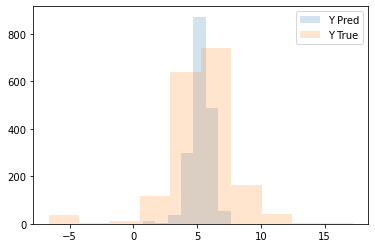

In [208]:
def ytrue_pred_hist(y,ypred):
    plt.hist(ypred,alpha=0.2, label="Y Pred")
    plt.hist(np.array(y),alpha=0.2, label="Y True")
    plt.legend()
    plt.show()
ytrue_pred_hist(y,ypred)

ok, i think I'm seeing how to use skorch to automatically search through hyperparams...
* maybe visualize which types of params were better?
* series of distributions
* can I also change the optimizer? all the other parts I want to vary?
* then try with multitask?

In [52]:
def parity_plot(model,ytrue,ypred, pearson):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

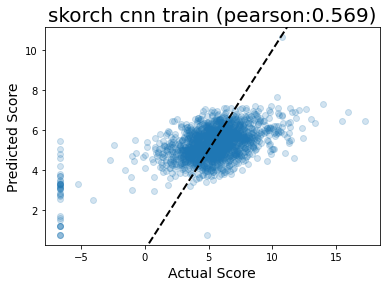

In [53]:
parity_plot("skorch cnn train", y, ypred,p2[0])

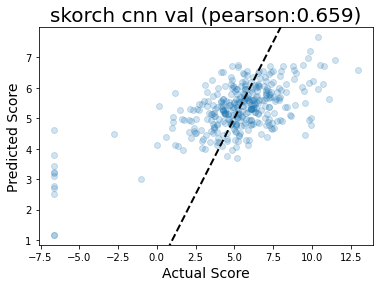

In [54]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
ypred_val = search.best_estimator_.predict(Xval)

pearson_val = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val.flatten())

parity_plot("skorch cnn val", yval, ypred_val,pearson_val[0])

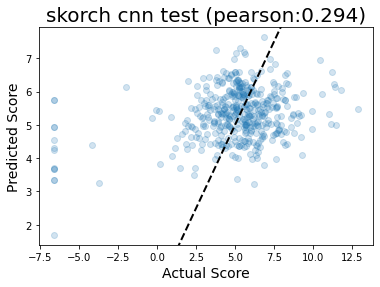

In [55]:
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')
ypred_test = search.best_estimator_.predict(Xtest)

pearson_test = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test.flatten())

parity_plot("skorch cnn test", ytest, ypred_test,pearson_test[0])

In [56]:
b = search.best_estimator_

In [57]:
for i in b.module_.children():
    if type(i) == nn.Sequential:
        for child in i:
            if type(child) == nn.Conv2d:
                print(child.weight)

Parameter containing:
tensor([[[[-0.0492, -0.1319, -0.1338,  ...,  0.1245,  0.0749,  0.0060],
          [ 0.0414, -0.0066,  0.1261,  ...,  0.0850,  0.0729,  0.0187],
          [ 0.1238, -0.0061,  0.1383,  ...,  0.0774,  0.0849, -0.1762],
          [ 0.0212, -0.0127,  0.0949,  ...,  0.1382, -0.1770, -0.1521]]],


        [[[-0.1415,  0.0869,  0.0841,  ..., -0.1120, -0.1524,  0.1761],
          [-0.0656, -0.1416, -0.1225,  ...,  0.0786,  0.0954, -0.1050],
          [-0.0167, -0.0239,  0.1166,  ...,  0.0396, -0.0343,  0.1392],
          [-0.0020,  0.0178,  0.1165,  ..., -0.0610, -0.1288,  0.1653]]],


        [[[ 0.0824, -0.0750, -0.1287,  ...,  0.0906,  0.0544,  0.1087],
          [ 0.0993, -0.1138, -0.0614,  ..., -0.0755, -0.1448,  0.0971],
          [ 0.0747,  0.1471, -0.0959,  ...,  0.0405,  0.0436,  0.0879],
          [ 0.0393, -0.0015, -0.1035,  ...,  0.0451, -0.0783,  0.1410]]],


        ...,


        [[[ 0.0415,  0.0567,  0.1215,  ..., -0.1340,  0.0531, -0.0786],
          [ 0.1

In [58]:
b.score(Xval,yval)

0.287707302591239

# Run skorch with a Pytorch data loader

In [202]:
net_dl = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    iterator_train = log_ohe_train_dl,
    iterator_valid = log_ohe_val_dl
)

In [203]:
search_dl = RandomizedSearchCV(
    net_dl, 
    params, 
    n_iter=200, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [204]:
search_dl.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.0s finished


TypeError: 'DataLoader' object is not callable

The FAQ seems to say to NOT provide a Dataset if possible - skorch does Dataloader stuff under the hood? 

"skorch supports datasets as input but sklearn doesn’t. If it’s possible, you should provide your data in a non-dataset format, e.g. as a numpy array or torch tensor, extracted from your original dataset."
https://skorch.readthedocs.io/en/stable/user/FAQ.html#faq-how-do-i-use-a-pytorch-dataset-with-skorch

# Run Skorch with MT model

In [214]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [215]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
        )
        # define the multi task objectives?
        self.obj0   = nn.Linear(num_fc_nodes2,1)
        self.obj1   = nn.Linear(num_fc_nodes2,1)
        self.obj2   = nn.Linear(num_fc_nodes2,1)
        self.obj3   = nn.Linear(num_fc_nodes2,1)
        self.obj4   = nn.Linear(num_fc_nodes2,1)
        self.obj5   = nn.Linear(num_fc_nodes2,1)
        self.obj6   = nn.Linear(num_fc_nodes2,1)
        self.obj7   = nn.Linear(num_fc_nodes2,1)
        self.obj8   = nn.Linear(num_fc_nodes2,1)
        self.obj9   = nn.Linear(num_fc_nodes2,1)
        self.obj10  = nn.Linear(num_fc_nodes2,1)
        self.obj11  = nn.Linear(num_fc_nodes2,1)
        

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        
        out0 = self.obj0(out).squeeze(1)
        out1 = self.obj1(out).squeeze(1)
        out2 = self.obj2(out).squeeze(1)
        out3 = self.obj3(out).squeeze(1)
        out4 = self.obj4(out).squeeze(1)
        out5 = self.obj5(out).squeeze(1)
        out6 = self.obj6(out).squeeze(1)
        out7 = self.obj7(out).squeeze(1)
        out8 = self.obj8(out).squeeze(1)
        out9 = self.obj9(out).squeeze(1)
        out10 = self.obj10(out).squeeze(1)
        out11 = self.obj11(out).squeeze(1)
        
        #print("out0", out0.shape)
        all_outs = torch.stack([out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11])
        #print("all_outs",all_outs.shape)
#         print("convert list to tensor?")
#         all_outs = torch.tensor(all_outs)
#         print(all_outs.shape)
        #print(all_outs)
#    shape fix here??
        #print("all_outs shape", all_outs.shape)
        #print("transpose?", all_outs.T.shape)
        
        #all_outs.squeeze(2)
        
        return all_outs.T

In [216]:
def make_multi_skorch_dfs(df,seq_col='seq',target_cols=conditions):
    ### EDIT THIS FOR MULTI TASK!
    
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [217]:
Xm,ym = make_multi_skorch_dfs(log_full_train_df, seq_col='upstream_region')

In [218]:
ym.shape

torch.Size([1763, 12])

In [219]:
Xm.shape

torch.Size([1763, 300, 4])

In [220]:
mnet_regr = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=100,
    lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

In [221]:
ym

tensor([[ 5.9067,  5.4316,  5.0675,  ...,  5.4481,  5.3852,  5.4492],
        [ 5.0850,  4.7722,  4.2088,  ...,  4.4163,  4.3677,  4.5344],
        [ 4.7662,  4.7673,  3.6885,  ...,  4.5253,  5.0318,  5.1032],
        ...,
        [ 5.5254,  4.9950,  4.3385,  ...,  4.5561,  5.6211,  5.4797],
        [ 4.9626,  4.5779,  4.3017,  ...,  4.7243,  5.3220,  5.4330],
        [10.4433, 10.2085,  8.9836,  ...,  8.9481,  8.3219,  8.3617]])

In [222]:
mnet_regr.fit(Xm, ym)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       33.6401       32.5483  0.0611
      2       33.2623       32.1771  0.0616
      3       32.8856       31.8042  0.0606
      4       32.5051       31.4249  0.0605
      5       32.1163       31.0348  0.0606
      6       31.7146       30.6295  0.0613
      7       31.2955       30.2043  0.0610
      8       30.8544       29.7548  0.0599
      9       30.3865       29.2761  0.0598
     10       29.8868       28.7633  0.0598
     11       29.3502       28.2112  0.0594
     12       28.7713       27.6146  0.0596
     13       28.1449       26.9682  0.0599
     14       27.4655       26.2672  0.0595
     15       26.7282       25.5069  0.0593
     16       25.9288       24.6841  0.0591
     17       25.0642       23.7969  0.0590
     18       24.1333       22.8459  0.0604
     19       23.1377       21.8348  0.0604
     20       22.0825       20.7712  0.0608
     21       20.9769       19.6

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

In [223]:
mnet_regr.predict(Xm)

array([[5.5344706, 5.3362503, 5.1078553, ..., 5.458872 , 5.88742  ,
        5.872032 ],
       [5.5454082, 5.249923 , 5.0072546, ..., 5.35991  , 5.8974648,
        5.7588468],
       [5.576158 , 5.430917 , 5.110507 , ..., 5.544123 , 5.833728 ,
        5.976501 ],
       ...,
       [5.441227 , 5.2400894, 4.8815727, ..., 5.3284035, 5.7126746,
        5.747125 ],
       [5.351719 , 5.225976 , 4.8683257, ..., 5.2553773, 5.7196226,
        5.689351 ],
       [5.956563 , 5.6545105, 5.4477453, ..., 5.83062  , 6.246385 ,
        6.1873646]], dtype=float32)

In [224]:
ym.shape

torch.Size([1763, 12])

In [225]:
ympred_train = mnet_regr.predict(Xm)

In [226]:
ympred_train.shape

(1763, 12)

In [227]:
ym[0]

tensor([5.9067, 5.4316, 5.0675, 4.2415, 5.8980, 6.0226, 6.3058, 5.9357, 6.6294,
        5.4481, 5.3852, 5.4492])

In [228]:
ympred_train[0]

array([5.5344706, 5.3362503, 5.1078553, 4.6036663, 5.678033 , 5.489679 ,
       5.4866962, 5.527484 , 5.864701 , 5.458872 , 5.88742  , 5.872032 ],
      dtype=float32)

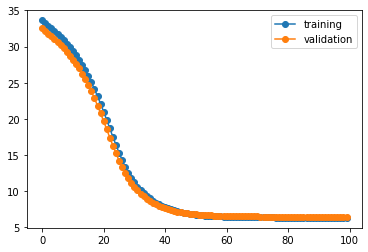

In [229]:
train_loss = mnet_regr.history[:, 'train_loss']
valid_loss = mnet_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [230]:
ym.shape

torch.Size([1763, 12])

### Loop through each task and look at parity plot?

In [231]:
def check_mt_pred_results(y,ypred):
    '''
    Check individual task predictions within MT?
    '''
    for i in cond_dict:
        task=cond_dict[i]
        print(f"task:{task}")
        yi = y[:,i]
        ypredi = ypred[:,i]

        pr = scipy.stats.pearsonr(np.array(yi).flatten(),ypredi.flatten())
        ytrue_pred_hist(yi,ypredi)
        parity_plot(f"skorch cnn {task}", yi, ypredi,pr[0])

task:uMax


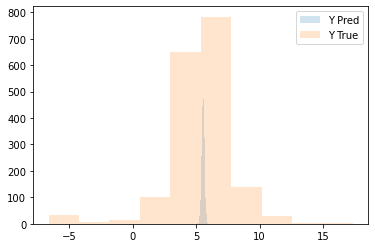

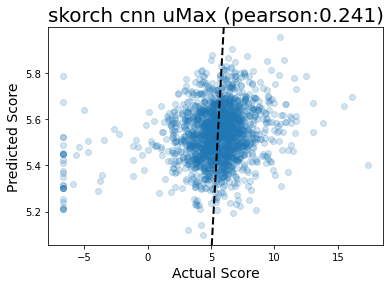

task:lowO2_fast_growth


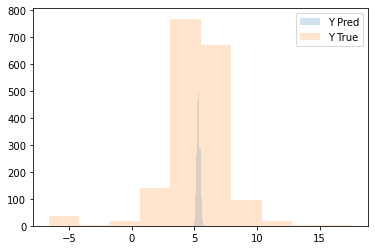

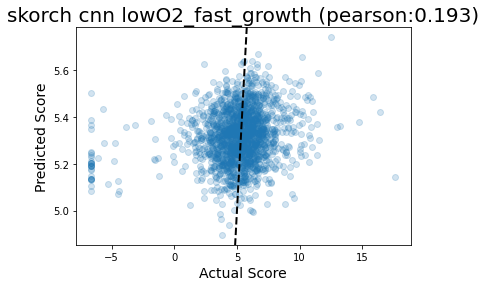

task:lowCH4


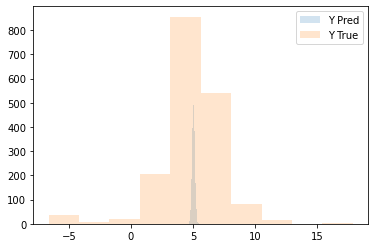

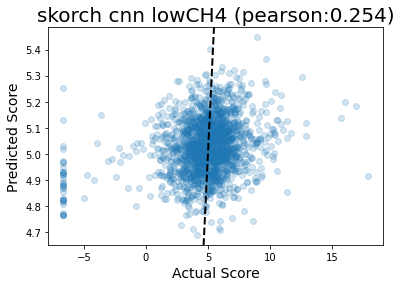

task:MeOH


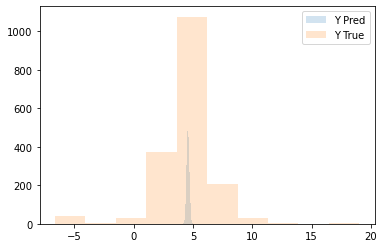

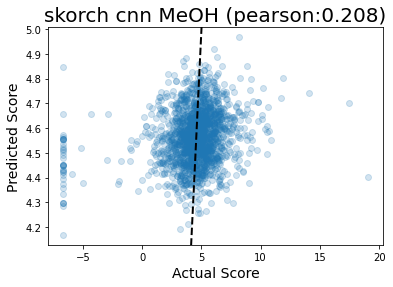

task:NoCu


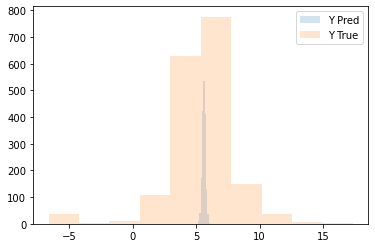

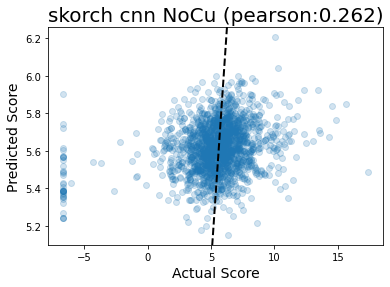

task:medCu


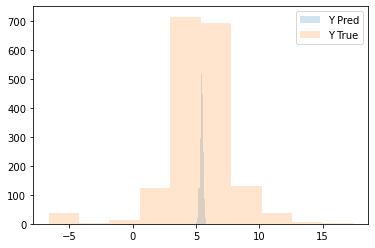

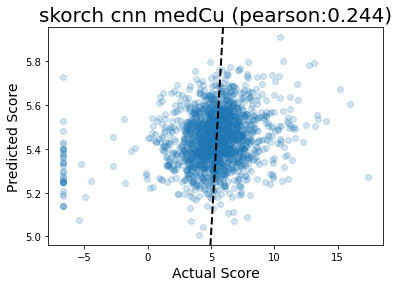

task:highCu


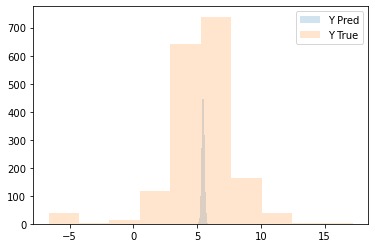

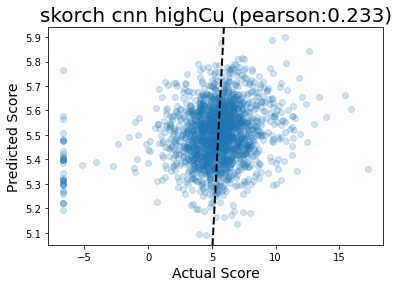

task:lowCu


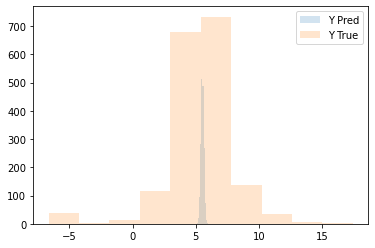

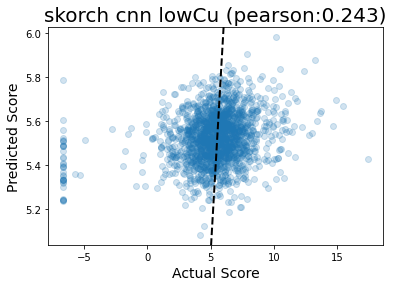

task:highO2_slow_growth


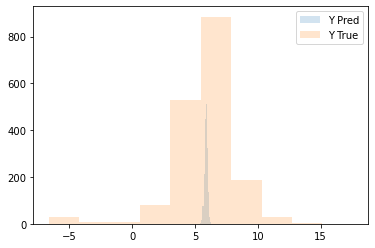

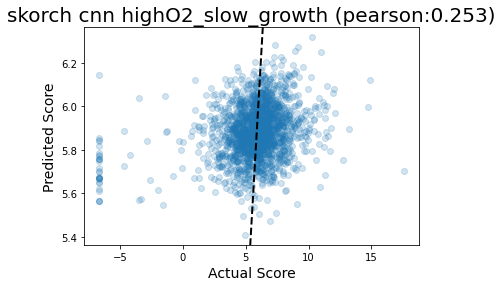

task:NO3_lowO2_slow_growth


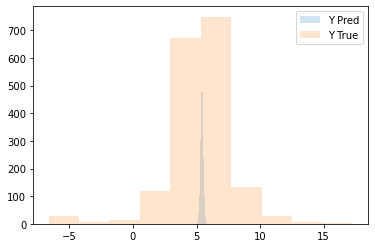

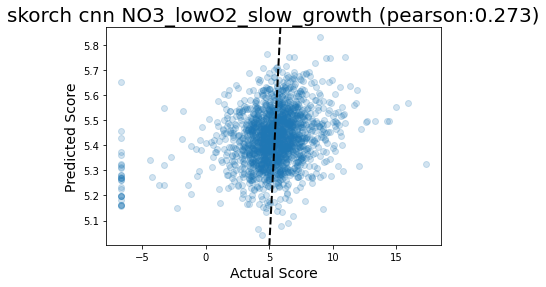

task:WithLanthanum


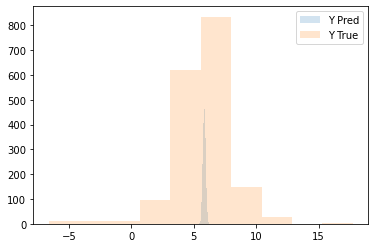

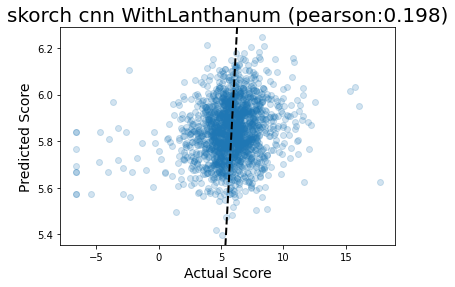

task:NoLanthanum


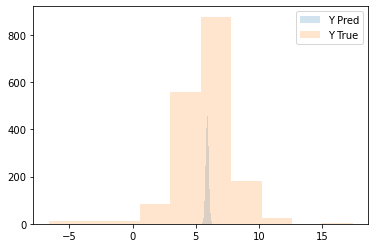

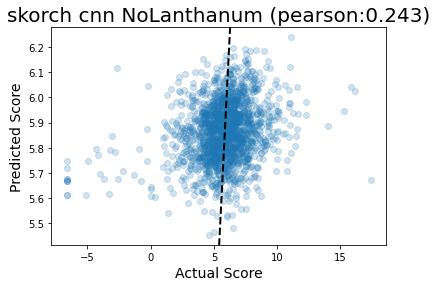

In [232]:
check_mt_pred_results(ym, ympred_train)

# skorch param search with MT

In [233]:
params = {
    'lr': [0.001, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

mnet_search = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=100,
    lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

m_search = RandomizedSearchCV(
    mnet_search, 
    params, 
    n_iter=100, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,#cv, 
    random_state=1,
    verbose=2
)

In [234]:
m_search.fit(Xm, ym)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 16.7min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       26.5641       15.9861  0.0751
      2       12.2091        7.9437  0.0722


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.9min finished


      3        7.2366        6.7056  0.0723
      4        6.5458        6.6444  0.0711
      5        6.4636        6.6188  0.0712
      6        6.4267        6.5915  0.0719
      7        6.3981        6.5677  0.0720
      8        6.3740        6.5476  0.0722
      9        6.3528        6.5304  0.0746
     10        6.3334        6.5152  0.0751
     11        6.3152        6.5013  0.0736
     12        6.2977        6.4883  0.0724
     13        6.2807        6.4759  0.0765
     14        6.2639        6.4640  0.0723
     15        6.2472        6.4523  0.0719
     16        6.2305        6.4407  0.0723
     17        6.2138        6.4293  0.0723
     18        6.1969        6.4179  0.0722
     19        6.1799        6.4065  0.0719
     20        6.1628        6.3951  0.0723
     21        6.1454        6.3836  0.0725
     22        6.1279        6.3721  0.0723
     23        6.1102        6.3606  0.0727
     24        6.0923        6.3489  0.0728
     25        6.0743        6.3

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN_Multi'>,
  module__seq_len=300,
),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class 't

In [237]:
m_search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 16), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=4560, out_features=25, bias=True)
      (3): Linear(in_features=25, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, b

In [238]:
m_search.best_params_

{'optimizer': torch.optim.rmsprop.RMSprop,
 'module__num_filters': 16,
 'module__num_fc_nodes1': 25,
 'module__kernel_size': 16,
 'lr': 0.0001}

In [240]:
mres_df = pd.DataFrame(m_search.cv_results_)
mres_df['opt_name'] = mres_df['param_optimizer'].apply(lambda x: x.__name__)
mres_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,14.177788,1.367561,0.011121,0.000243,<class 'torch.optim.adam.Adam'>,16,10,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-12.409496,-11.830884,-13.517353,-12.266438,-13.793412,-12.763517,0.757783,58,Adam
1,11.794365,0.448145,0.012098,0.001310,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.929592,-6.700378,-12.749442,-6.305992,-9.181162,-8.373313,2.406657,41,Adam
2,12.532563,0.167576,0.013338,0.001289,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-8.852070,-6.364292,-8.415924,-7.751035,-10.322305,-8.341125,1.299831,40,Adam
3,11.701076,0.471533,0.011704,0.000656,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-7.186683,-6.712734,-8.267080,-6.757535,-9.489748,-7.682756,1.062988,35,Adam
4,8.033701,0.831813,0.012473,0.001837,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.465118,-4.989299,-7.396376,-5.337299,-7.711785,-6.379976,1.080295,14,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.672258,0.198422,0.013335,0.001361,<class 'torch.optim.adagrad.Adagrad'>,128,25,8,0.001,{'optimizer': <class 'torch.optim.adagrad.Adag...,-6.386578,-5.957352,-7.246610,-6.130351,-8.331460,-6.810470,0.880192,25,Adagrad
96,7.846431,0.491809,0.012112,0.000808,<class 'torch.optim.sgd.SGD'>,16,10,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-29.822756,-32.432270,-33.568485,-30.712936,-35.987682,-32.504826,2.175835,100,SGD
97,11.153773,0.118676,0.011233,0.000456,<class 'torch.optim.adam.Adam'>,32,50,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-15.868276,-16.675558,-14.740551,-15.868892,-18.368792,-16.304414,1.202079,77,Adam
98,7.584228,0.015769,0.011057,0.000653,<class 'torch.optim.sgd.SGD'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-30.960747,-33.247494,-31.936460,-30.893911,-34.571453,-32.322013,1.411217,98,SGD


In [241]:
sm_mres_df = mres_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [242]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [243]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [244]:
ymsearch_pred_train = m_search.best_estimator_.predict(Xm)

task:uMax


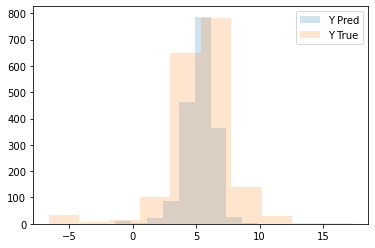

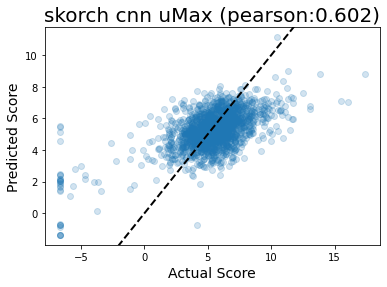

task:lowO2_fast_growth


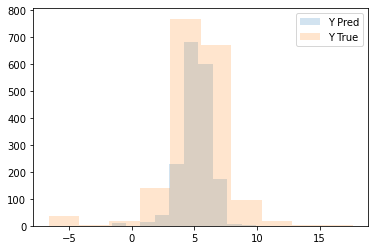

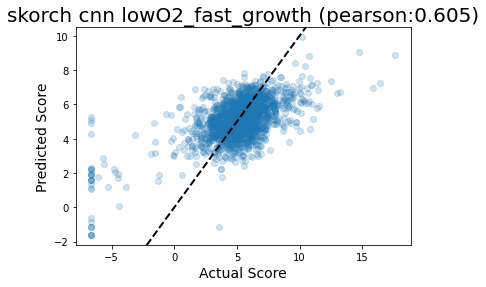

task:lowCH4


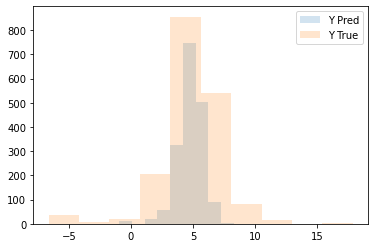

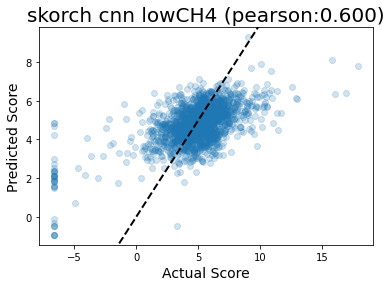

task:MeOH


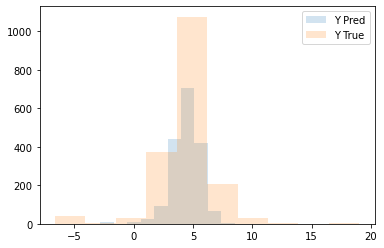

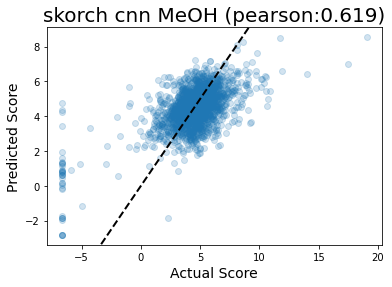

task:NoCu


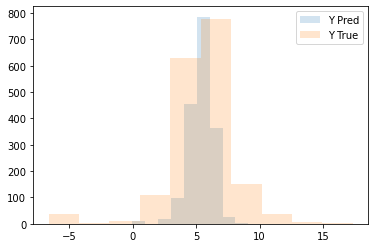

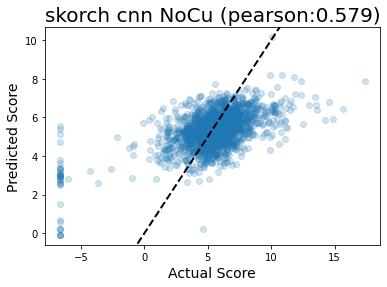

task:medCu


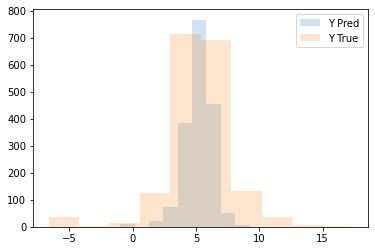

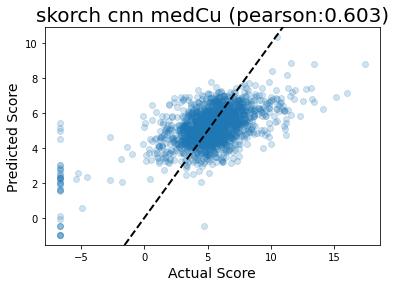

task:highCu


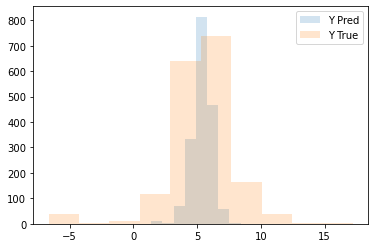

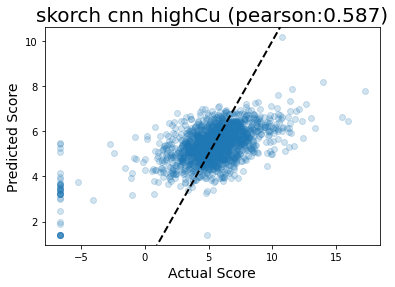

task:lowCu


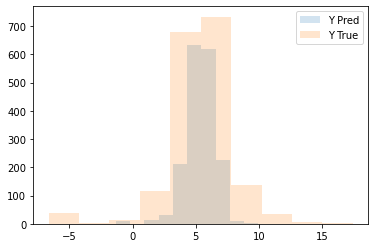

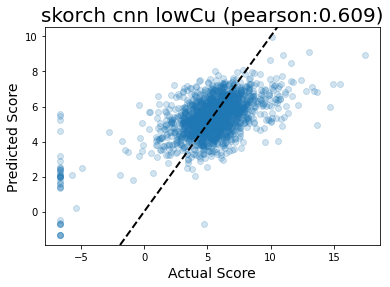

task:highO2_slow_growth


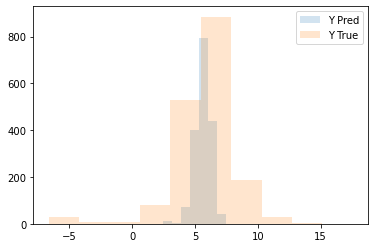

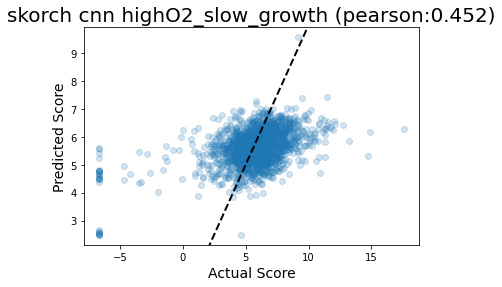

task:NO3_lowO2_slow_growth


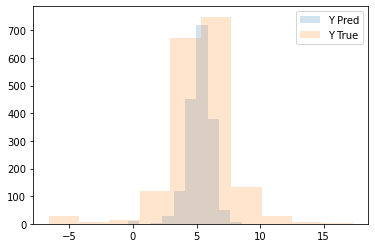

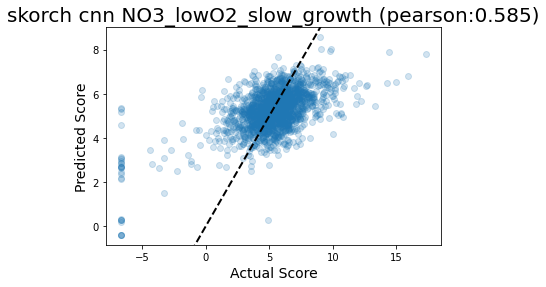

task:WithLanthanum


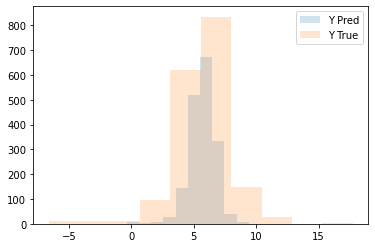

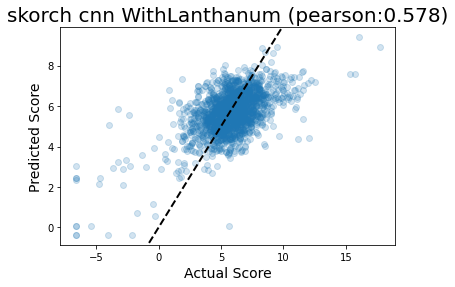

task:NoLanthanum


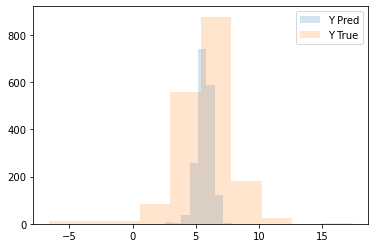

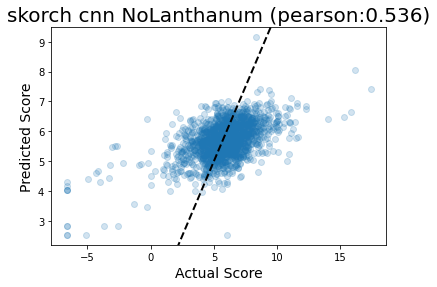

In [245]:
check_mt_pred_results(ym, ymsearch_pred_train)